# Step 4: Build models and tune hyperparameters


The purpose of this program is to build a classifier model for each of the 8 justices. I first run 4 different calssification algorithms for each justice, then I use grid search cross validation to optimize hyperparameters for teh SGD model. These optimized hyperparameters will be used in the next notebook: models_with_tuned_params.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

#other sklearn tools
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#NLP tools
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer



Read in all data for justices:

In [55]:
breyer_df = pd.read_pickle("df_merged_breyer.pkl")
sotomayor_df = pd.read_pickle("df_merged_sotomayor.pkl")
alito_df = pd.read_pickle("df_merged_alito.pkl")
thomas_df = pd.read_pickle("df_merged_thomas.pkl")
kavanaugh_df = pd.read_pickle("df_merged_kavanaugh.pkl")
roberts_df = pd.read_pickle("df_merged_roberts.pkl")
gorsuch_df = pd.read_pickle("df_merged_gorsuch.pkl")
kagan_df = pd.read_pickle("df_merged_kagan.pkl")

Define function that will be used for all justice models (four algorithms were used for experimentation purposes, though the expectation is that SGD words the best for this sentiment analysis question):

In [56]:
def all_models(df):
    '''This function takes in a dataframe of a justice and prints out the confustion matrix and train/test 
    accuracy for each of 4 different classifiers. Parameters were hand-picked. After initial model fittings, 
    a grid search will be run to optimize the chosen model.'''
    
    X=np.array(df.pet_text)
    y=np.array(df.final_vote)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)
    
    
    #classes = np.array([0, 1]) 
    
    vect = TfidfVectorizer()
    X_train = vect.fit_transform(X_train)
    X_test = vect.transform(X_test)
    
    print("Ratio")
    print(np.bincount(y_train.astype(int))[1]/len(y_train))
    print()
    
    #Stochasic gradient descent
    print("SGD")
    clf = SGDClassifier(loss='log', random_state=1, penalty='l1', alpha=0.0001)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_pred,y_test))
    plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues)  
    plt.show()
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score: {clf.score(X_test, y_test)}')
    print()
    
    #Logistic Regression
    print("Logistic")
    clf = LogisticRegression(random_state=0, solver='liblinear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_pred,y_test))
    plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues)  
    plt.show()
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score: {clf.score(X_test, y_test)}')
    print()
    
    #K nearest neighbors
    print("KNN")
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_pred,y_test))
    plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues)  
    plt.show()
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score: {clf.score(X_test, y_test)}')
    print()
    
    #Support vector machines
    print("SVM")
    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_pred,y_test))
    plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues)  
    plt.show()
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score: {clf.score(X_test, y_test)}')

Create two tokenizer options for grid search that will be run for each justice (one uses a porter stemmer, the other does not):

In [57]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizerporter(text):
    return [porter.stem(word) for word in text.split()]

# Breyer

In [58]:
breyer_df=breyer_df.reset_index()
print(len(breyer_df))
breyer_df.isnull().sum()==0

792


index            True
case_num         True
pet_name         True
res_name         True
pet_text         True
res_text         True
dateArgument    False
partyWinning     True
justiceName      True
majority         True
final_vote       True
dtype: bool

In [59]:
breyer_df.final_vote.value_counts()

1.0    488
0.0    304
Name: final_vote, dtype: int64

Ratio
0.6169811320754717

SGD
[[ 55  41]
 [ 46 120]]


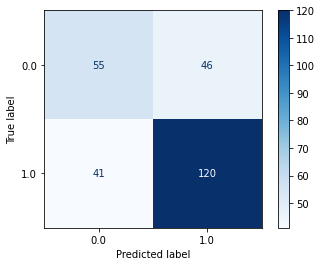

Train score: 0.9679245283018868
Test score: 0.6679389312977099

Logistic
[[ 29  21]
 [ 72 140]]


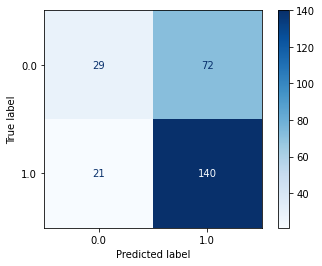

Train score: 0.8660377358490566
Test score: 0.6450381679389313

KNN
[[ 18  18]
 [ 83 143]]


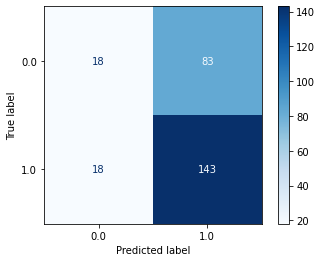

Train score: 0.6886792452830188
Test score: 0.6145038167938931

SVM
[[  0   0]
 [101 161]]


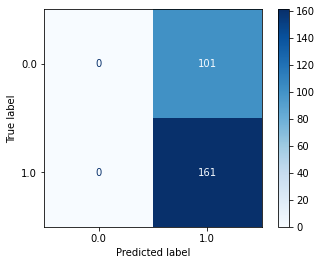

Train score: 0.6169811320754717
Test score: 0.6145038167938931


In [60]:
all_models(breyer_df)

In [61]:
#Breyer
#logistic and svm are only predicting negative
#Moving forward with analysis using sgd and knn

### Grid search- SGD

In [62]:
X=np.array(breyer_df.pet_text)
y=np.array(breyer_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')

param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 40.8min finished


Best parameter set: {'clf__alpha': 0.0001, 'clf__n_iter_no_change': 7, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7fc283e80b90>, 'vect__use_idf': False} 
CV Accuracy: 0.696
Test Accuracy: 0.683


# Sotomayor

In [63]:
sotomayor_df=sotomayor_df.reset_index()
print(len(sotomayor_df))
sotomayor_df.isnull().sum()==0

580


index           True
case_num        True
pet_name        True
res_name        True
pet_text        True
res_text        True
dateArgument    True
partyWinning    True
justiceName     True
majority        True
final_vote      True
dtype: bool

In [64]:
sotomayor_df.final_vote.value_counts()

1.0    348
0.0    232
Name: final_vote, dtype: int64

Ratio
0.6005154639175257

SGD
[[26 30]
 [51 85]]


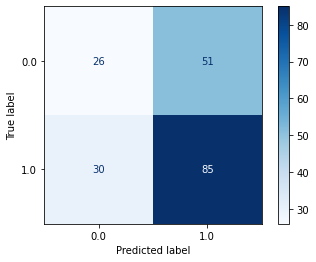

Train score: 0.9922680412371134
Test score: 0.578125

Logistic
[[  2   3]
 [ 75 112]]


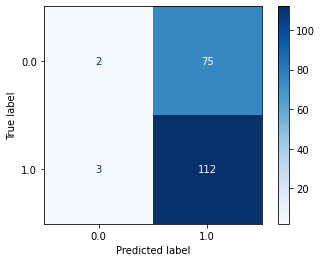

Train score: 0.8247422680412371
Test score: 0.59375

KNN
[[  4  15]
 [ 73 100]]


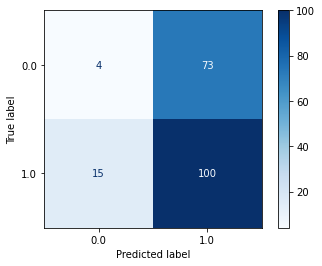

Train score: 0.7628865979381443
Test score: 0.5416666666666666

SVM
[[  0   0]
 [ 77 115]]


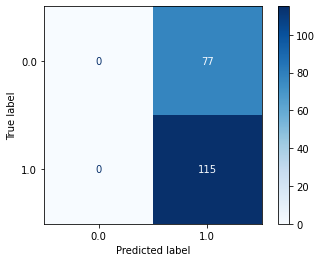

Train score: 0.6005154639175257
Test score: 0.5989583333333334


In [65]:
all_models(sotomayor_df)

### Grid search- SGD

In [67]:
X=np.array(sotomayor_df.pet_text)
y=np.array(sotomayor_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))




dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1025 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1997 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2604 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 3293 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 4062 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 4913 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 32.5min finished


Best parameter set: {'clf__alpha': 0.001, 'clf__n_iter_no_change': 3, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizerporter at 0x7fc283e80290>, 'vect__use_idf': False} 
CV Accuracy: 0.655
Test Accuracy: 0.562


# Kagan

In [68]:
kagan_df=kagan_df.reset_index()
print(len(kagan_df))
kagan_df.isnull().sum()==0

486


index           True
case_num        True
pet_name        True
res_name        True
pet_text        True
res_text        True
dateArgument    True
partyWinning    True
justiceName     True
majority        True
final_vote      True
dtype: bool

In [69]:
kagan_df.final_vote.value_counts()

1.0    303
0.0    183
Name: final_vote, dtype: int64

Ratio
0.6246153846153846

SGD
[[28 26]
 [33 74]]


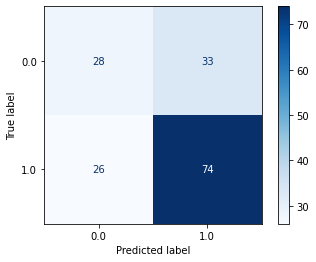

Train score: 0.9876923076923076
Test score: 0.6335403726708074

Logistic
[[  1   0]
 [ 60 100]]


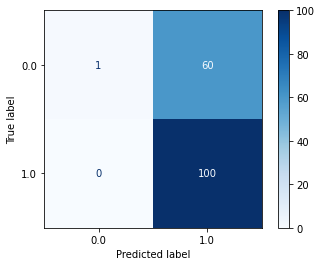

Train score: 0.7292307692307692
Test score: 0.6273291925465838

KNN
[[ 3  3]
 [58 97]]


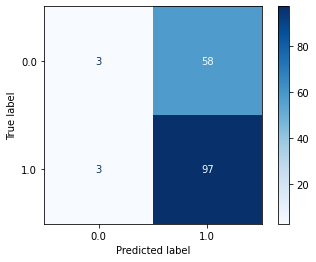

Train score: 0.6861538461538461
Test score: 0.6211180124223602

SVM
[[  0   0]
 [ 61 100]]


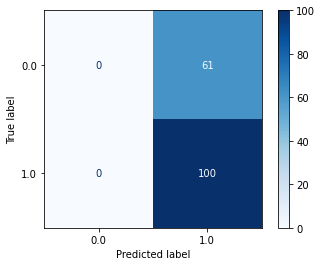

Train score: 0.6246153846153846
Test score: 0.6211180124223602


In [70]:
all_models(kagan_df)

### Grid search SGD

In [72]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizerporter(text):
    return [porter.stem(word) for word in text.split()]

X=np.array(kagan_df.pet_text)
y=np.array(kagan_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))


dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1025 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1997 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2604 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 3293 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4062 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 4913 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 25.6min finished


Best parameter set: {'clf__alpha': 0.0001, 'clf__n_iter_no_change': 9, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7fc283ba3710>, 'vect__use_idf': True} 
CV Accuracy: 0.655
Test Accuracy: 0.634


# Kavanaugh

In [73]:
kavanaugh_df=kavanaugh_df.reset_index()
print(len(kavanaugh_df))
kavanaugh_df.isnull().sum()==0

92


index           True
case_num        True
pet_name        True
res_name        True
pet_text        True
res_text        True
dateArgument    True
partyWinning    True
justiceName     True
majority        True
final_vote      True
dtype: bool

In [74]:
kavanaugh_df.final_vote.value_counts()

1.0    54
0.0    38
Name: final_vote, dtype: int64

Ratio
0.5901639344262295

SGD
[[ 6  5]
 [ 7 13]]


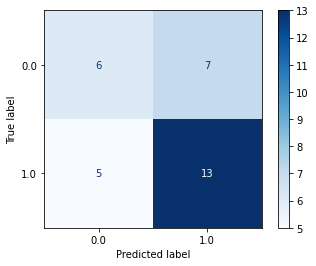

Train score: 0.9836065573770492
Test score: 0.6129032258064516

Logistic
[[ 2  2]
 [11 16]]


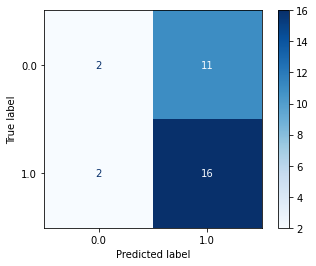

Train score: 0.8688524590163934
Test score: 0.5806451612903226

KNN
[[11 12]
 [ 2  6]]


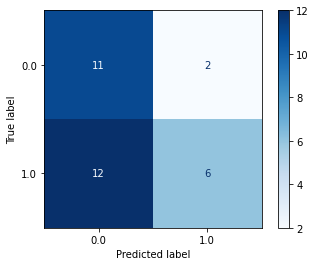

Train score: 0.5573770491803278
Test score: 0.5483870967741935

SVM
[[ 0  0]
 [13 18]]


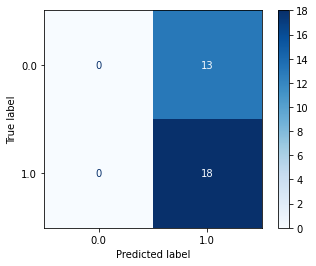

Train score: 0.5901639344262295
Test score: 0.5806451612903226


In [75]:
all_models(kavanaugh_df)

### Grid search SGD

In [76]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizerporter(text):
    return [porter.stem(word) for word in text.split()]

X=np.array(kavanaugh_df.pet_text)
y=np.array(kavanaugh_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))


dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1037 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2009 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3305 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4074 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4925 tasks      | elapsed:  4.4min


Best parameter set: {'clf__alpha': 0.001, 'clf__n_iter_no_change': 5, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7fc283c05950>, 'vect__use_idf': True} 
CV Accuracy: 0.654
Test Accuracy: 0.613


[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 21.4min finished


# Thomas

In [77]:
thomas_df=thomas_df.reset_index()
print(len(thomas_df))
thomas_df.isnull().sum()==0

796


index            True
case_num         True
pet_name         True
res_name         True
pet_text         True
res_text         True
dateArgument    False
partyWinning     True
justiceName      True
majority         True
final_vote       True
dtype: bool

In [78]:
thomas_df.final_vote.value_counts()

1.0    462
0.0    334
Name: final_vote, dtype: int64

Ratio
0.5797373358348968

SGD
[[  4   3]
 [106 150]]


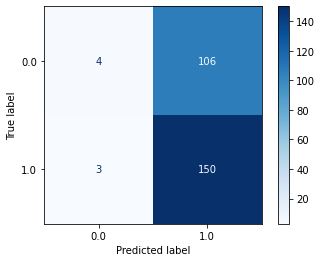

Train score: 0.6022514071294559
Test score: 0.5855513307984791

Logistic
[[  4   3]
 [106 150]]


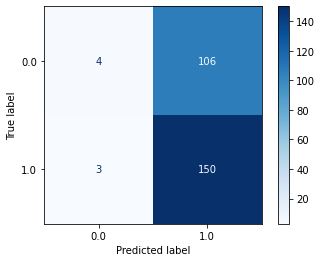

Train score: 0.5966228893058161
Test score: 0.5855513307984791

KNN
[[  4   3]
 [106 150]]


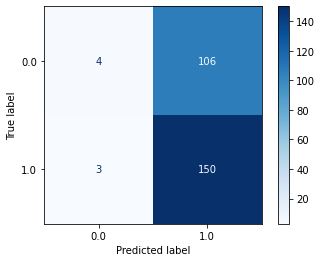

Train score: 0.5928705440900562
Test score: 0.5855513307984791

SVM
[[  0   0]
 [110 153]]


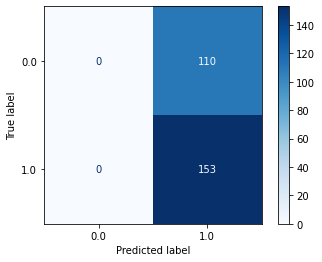

Train score: 0.5797373358348968
Test score: 0.5817490494296578


In [79]:
all_models(thomas_df)

### Grid search SGD

In [80]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizerporter(text):
    return [porter.stem(word) for word in text.split()]

X=np.array(thomas_df.pet_text)
y=np.array(thomas_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))




dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1253 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1698 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 2230 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4620 tasks      | elapsed:  9.5min


Best parameter set: {'clf__alpha': 0.001, 'clf__n_iter_no_change': 3, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizerporter at 0x7fc28360d3b0>, 'vect__use_idf': False} 
CV Accuracy: 0.595
Test Accuracy: 0.586


[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed:  9.6min finished


# Alito

In [81]:

alito_df=alito_df.reset_index()
print(len(alito_df))
alito_df.isnull().sum()==0

738


index            True
case_num         True
pet_name         True
res_name         True
pet_text         True
res_text         True
dateArgument    False
partyWinning     True
justiceName      True
majority         True
final_vote       True
dtype: bool

In [82]:
alito_df.final_vote.value_counts()

1.0    446
0.0    292
Name: final_vote, dtype: int64

Ratio
0.6052631578947368

SGD
[[ 28  30]
 [ 69 117]]


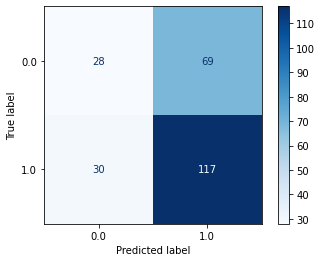

Train score: 0.9534412955465587
Test score: 0.5942622950819673

Logistic
[[ 14   5]
 [ 83 142]]


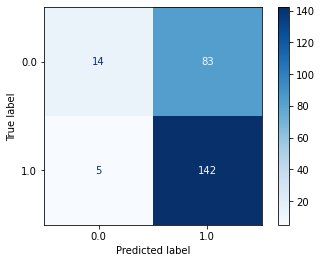

Train score: 0.8238866396761133
Test score: 0.639344262295082

KNN
[[ 12   9]
 [ 85 138]]


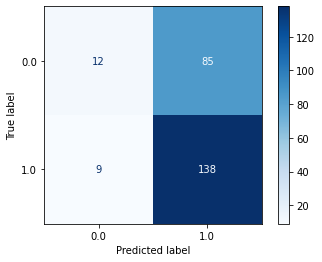

Train score: 0.6781376518218624
Test score: 0.6147540983606558

SVM
[[  0   0]
 [ 97 147]]


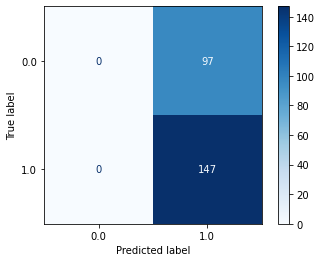

Train score: 0.6052631578947368
Test score: 0.6024590163934426


In [83]:
all_models(alito_df)

### Grid search SGD

In [84]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizerporter(text):
    return [porter.stem(word) for word in text.split()]

X=np.array(alito_df.pet_text)
y=np.array(alito_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))




dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 79.3min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 80.4min finished


Best parameter set: {'clf__alpha': 0.001, 'clf__n_iter_no_change': 9, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'h

# Gorsuch

In [85]:
gorsuch_df=gorsuch_df.reset_index()
print(len(gorsuch_df))
gorsuch_df.isnull().sum()==0

154


index           True
case_num        True
pet_name        True
res_name        True
pet_text        True
res_text        True
dateArgument    True
partyWinning    True
justiceName     True
majority        True
final_vote      True
dtype: bool

In [86]:
gorsuch_df.final_vote.value_counts()

1.0    92
0.0    62
Name: final_vote, dtype: int64

Ratio
0.6019417475728155

SGD
[[15 13]
 [ 6 17]]


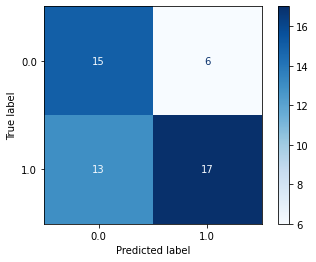

Train score: 0.9514563106796117
Test score: 0.6274509803921569

Logistic
[[15 11]
 [ 6 19]]


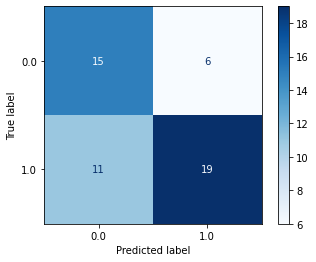

Train score: 0.9029126213592233
Test score: 0.6666666666666666

KNN
[[ 7  2]
 [14 28]]


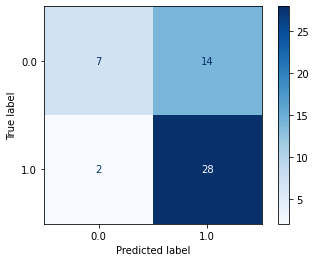

Train score: 0.6310679611650486
Test score: 0.6862745098039216

SVM
[[ 0  0]
 [21 30]]


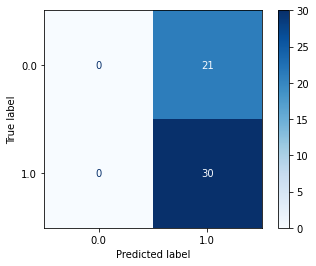

Train score: 0.6019417475728155
Test score: 0.5882352941176471


In [87]:
all_models(gorsuch_df)

### Grid search SGD


In [88]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizerporter(text):
    return [porter.stem(word) for word in text.split()]

X=np.array(gorsuch_df.pet_text)
y=np.array(gorsuch_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer()

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],# unigrams or bigrams
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizerporter],
               'vect__use_idf':[True,False],
               'clf__penalty': ['l1', 'l2'],
               'clf__n_iter_no_change': [3,5,7,9],
               'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))




dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 1037 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2009 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3305 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4074 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4925 tasks      | elapsed:  6.6min


Best parameter set: {'clf__alpha': 0.001, 'clf__n_iter_no_change': 3, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 2), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'h

[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed:  6.9min finished


# Roberts

In [89]:
roberts_df=roberts_df.reset_index()
print(len(roberts_df))
roberts_df.isnull().sum()==0

752


index            True
case_num         True
pet_name         True
res_name         True
pet_text         True
res_text         True
dateArgument    False
partyWinning     True
justiceName      True
majority         True
final_vote       True
dtype: bool

In [90]:
roberts_df.final_vote.value_counts()

1.0    488
0.0    264
Name: final_vote, dtype: int64

Ratio
0.6481113320079522

SGD
[[ 24  24]
 [ 63 138]]


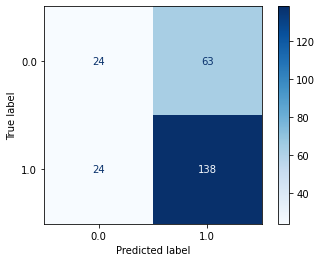

Train score: 0.9980119284294234
Test score: 0.6506024096385542

Logistic
[[  0   0]
 [ 87 162]]


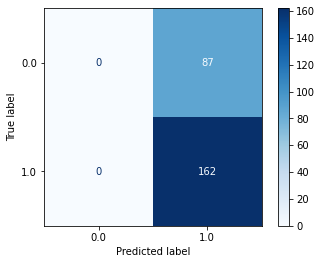

Train score: 0.705765407554672
Test score: 0.6506024096385542

KNN
[[ 11  16]
 [ 76 146]]


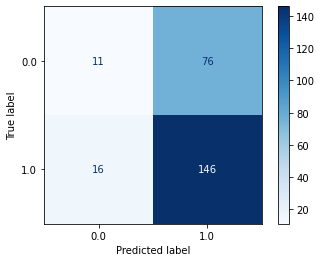

Train score: 0.7753479125248509
Test score: 0.6305220883534136

SVM
[[  0   0]
 [ 87 162]]


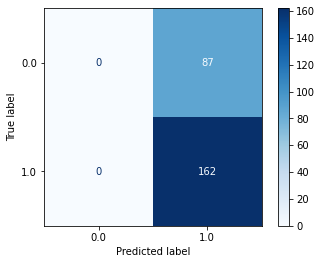

Train score: 0.6481113320079522
Test score: 0.6506024096385542


In [91]:
all_models(roberts_df)

### Grid search SGD

The larger grid search for Roberts was prohibitively expensive on my machine. I have made educated guesses about which parameters to run the grid search with so that it is a much smaller set of options.

In [98]:
X=np.array(roberts_df.pet_text)
y=np.array(roberts_df.final_vote)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

tfidf = TfidfVectorizer(tokenizer=tokenizerporter)

print(tfidf.get_params().keys())

nltk.download('stopwords')
stop = stopwords.words('english')


param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],
               'vect__stop_words': [stop, None],
               'vect__use_idf':[True,False],
               'clf__n_iter_no_change': [3,5],
               'clf__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1]}
              ]


lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(loss='log', random_state=1, penalty='l1'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anndi.russell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.4min finished
/Users/anndi.russell/opt/anaconda3/envs/cap1/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Best parameter set: {'clf__alpha': 0.001, 'clf__n_iter_no_change': 3, 'vect__ngram_range': (1, 2), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo